We first import the necessary packages.

In [10]:
import jax
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from model import ANODE
from utils import train_reverse, calculate_metrics_reverse
from flax.training import train_state
from functools import partial

# Enable 64 bit for more precision
jax.config.update("jax_enable_x64", True)

Our target distribution will be a Gaussian mixture model.

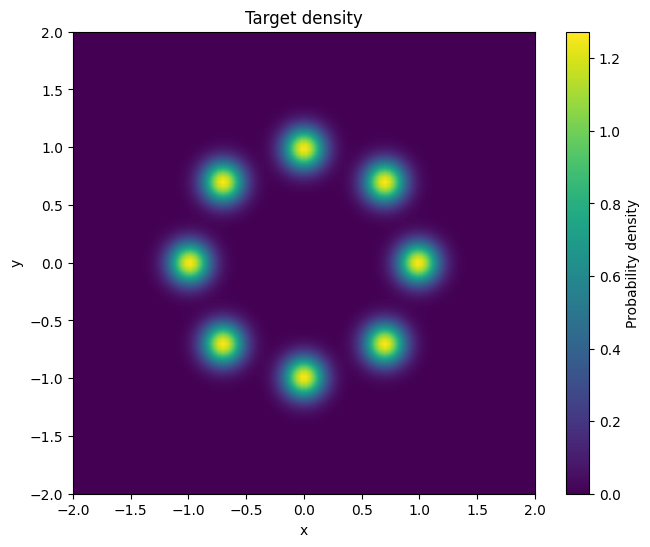

In [11]:
@partial(jax.jit, static_argnames=['n_components', 'radius', 'std'])
def gaussian_mixture_logpdf(x, n_components=8, radius=10.0, std=1.0):
    # Generate means equally spaced on a circle
    angles = jnp.linspace(0, 2 * jnp.pi, n_components, endpoint=False)
    means = radius * jnp.stack([jnp.cos(angles), jnp.sin(angles)], axis=1)  # Shape (n_components, 2)

    # Ensure x has a batch dimension if it's a single point
    batch_shape = x.shape[:-1]

    # Compute squared distances to each component mean
    x_expanded = jnp.expand_dims(x, axis=-2)  # Shape (..., 1, 2)
    means_expanded = means[None, ...]  # Shape (1, n_components, 2)
    squared_dists = jnp.sum((x_expanded - means_expanded) ** 2, axis=-1)  # Shape (..., n_components)

    # Compute log probabilities for each component
    log_probs = -0.5 * squared_dists / std**2 - jnp.log(2 * jnp.pi * std**2)

    # Log-sum-exp trick for numerical stability
    max_log_probs = jnp.max(log_probs, axis=-1, keepdims=True)
    log_density = max_log_probs.squeeze(-1) + jnp.log(jnp.sum(jnp.exp(log_probs - max_log_probs), axis=-1))

    # Adjust for equal mixture weights
    log_density = log_density - jnp.log(n_components)

    return log_density

@jax.jit
def log_p(x):
    return gaussian_mixture_logpdf(x, n_components=8, radius=1.0, std=1/8)

@jax.jit
def p(x):
    return jnp.exp(log_p(x))


# We plot the target density for visualization purposes
x_linspace = jnp.linspace(-2, 2, 100)
y_linspace = jnp.linspace(-2, 2, 100)
X, Y = jnp.meshgrid(x_linspace, y_linspace)
plotting_points = jnp.array([[X[x, y], Y[x, y]] for x in range(X.shape[0]) for y in range(Y.shape[1])])
target_density = p(plotting_points).reshape(X.shape)


plt.figure(figsize=(8, 6))
plt.imshow(target_density, extent=(-2, 2, -2, 2), origin='lower', cmap='viridis', interpolation='bilinear')
plt.colorbar(label='Probability density')
plt.title('Target density')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We will first create and train the NODE.

In [12]:
rng_key = jax.random.PRNGKey(0)

# NODE is a special case of ANODE with no augmentation
model_NODE = ANODE(
    num_hidden=16,
    sample_dims=2,
    aug_dims=0,
    n_blocks=4,
)

# Initialize the NODE
rng_key, init_key_NODE, init_sample_key_NODE = jax.random.split(rng_key, 3)
init_samples_NODE, _ = model_NODE.get_prior_samples(init_sample_key_NODE, n_samples=1)
params_NODE = model_NODE.init(init_key_NODE, 0.0, init_samples_NODE)

# Define the optimizer and create the training state
learning_rate = 1e-4
optimizer_NODE = optax.adam(learning_rate=learning_rate)
state_NODE = train_state.TrainState.create(
    apply_fn=model_NODE.sample,
    params=params_NODE,
    tx=optimizer_NODE,
)

# Train the model using the reverse KL divergence for 1000 steps on a batch size of 128 samples
rng_key, train_key_NODE = jax.random.split(rng_key)
state_NODE, train_metrics_NODE = train_reverse(state_NODE, train_key_NODE, log_p, num_epochs=1_000, batch_size=128)

# Calculate the final metrics of the model
rng_key, final_metrics_key_NODE = jax.random.split(rng_key)
final_metrics_NODE = calculate_metrics_reverse(state_NODE, final_metrics_key_NODE, 8 * 256, 20, log_p, train_metrics_NODE['loss'][-1])

Epoch 0: Loss: 14.3201, ESS: 0.0033 ± 0.0028, ACCEPT_RATE: 0.1527 ± 0.0111, INTEGRATE_ERROR: 0.4507 ± 0.4440
Epoch 1: Loss: 16.0890
Epoch 2: Loss: 13.5549
Epoch 3: Loss: 13.4128
Epoch 4: Loss: 12.0158
Epoch 5: Loss: 10.7038
Epoch 6: Loss: 12.1486
Epoch 7: Loss: 15.7802
Epoch 8: Loss: 11.1287
Epoch 9: Loss: 15.1020
Epoch 10: Loss: 11.8445
Epoch 11: Loss: 12.6078
Epoch 12: Loss: 13.1810
Epoch 13: Loss: 13.1314
Epoch 14: Loss: 15.3647
Epoch 15: Loss: 12.9336
Epoch 16: Loss: 13.3824
Epoch 17: Loss: 9.9616
Epoch 18: Loss: 11.7461
Epoch 19: Loss: 12.1284
Epoch 20: Loss: 12.0945
Epoch 21: Loss: 13.3789
Epoch 22: Loss: 15.0574
Epoch 23: Loss: 12.5694
Epoch 24: Loss: 11.5187
Epoch 25: Loss: 11.2039
Epoch 26: Loss: 13.9223
Epoch 27: Loss: 11.6779
Epoch 28: Loss: 13.2675
Epoch 29: Loss: 11.6589
Epoch 30: Loss: 11.1450
Epoch 31: Loss: 11.8356
Epoch 32: Loss: 10.4006
Epoch 33: Loss: 12.9053
Epoch 34: Loss: 11.0934
Epoch 35: Loss: 12.3083
Epoch 36: Loss: 13.9140
Epoch 37: Loss: 11.3209
Epoch 38: Los

We now visualize the learned distribution.

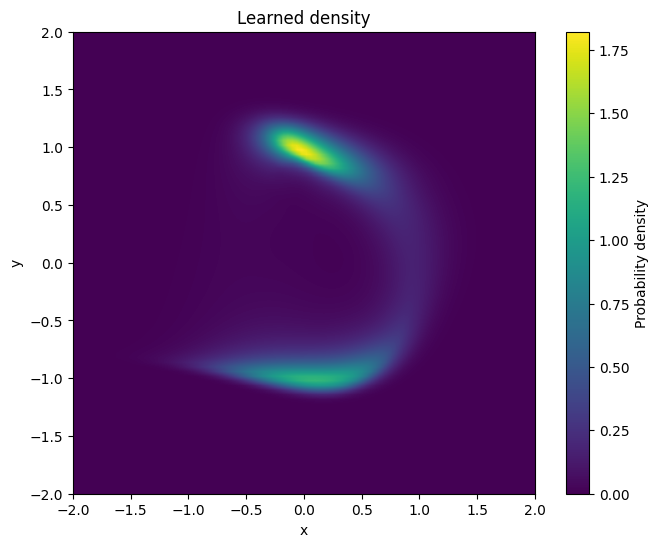

In [14]:
# Density of the NODE
rng_key, plotting_key_NODE = jax.random.split(rng_key)
_, log_densities_NODE = model_NODE.get_logp(state_NODE.params, plotting_points, plotting_key_NODE)
densities_NODE = jnp.exp(log_densities_NODE).reshape(X.shape)

plt.figure(figsize=(8, 6))
plt.imshow(densities_NODE, extent=(-2, 2, -2, 2), origin='lower', cmap='viridis', interpolation='bilinear')
plt.colorbar(label='Probability density')
plt.title('Learned density')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now, we will create and train the ANODE with 1 augmentation dimension.

In [15]:
# Create the ANODE
model_ANODE = ANODE(
    num_hidden=16,
    sample_dims=2,
    aug_dims=1,
    n_blocks=4,
)

# Initialize the ANODE
rng_key, init_key_ANODE, init_sample_key_ANODE = jax.random.split(rng_key, 3)
init_samples_ANODE, _ = model_ANODE.get_prior_samples(init_sample_key_ANODE, n_samples=1)
params_ANODE = model_ANODE.init(init_key_ANODE, 0.0, init_samples_ANODE)

# Define the optimizer and create the training state
optimizer_ANODE = optax.adam(learning_rate=learning_rate)
state_ANODE = train_state.TrainState.create(
    apply_fn=model_ANODE.sample,
    params=params_ANODE,
    tx=optimizer_ANODE,
)

# Train the model using the reverse KL divergence for 1000 steps on a batch size of 128 samples
rng_key, train_key_ANODE = jax.random.split(rng_key)
state_ANODE, train_metrics_ANODE = train_reverse(state_ANODE, train_key_ANODE, log_p, num_epochs=1_000, batch_size=128)

# Calculate the final metrics of the model
rng_key, final_metrics_key_ANODE = jax.random.split(rng_key)
final_metrics_ANODE = calculate_metrics_reverse(state_ANODE, final_metrics_key_ANODE, 8 * 256, 20, log_p, train_metrics_ANODE['loss'][-1])

Epoch 0: Loss: 12.7833, ESS: 0.0051 ± 0.0039, ACCEPT_RATE: 0.1586 ± 0.0120, INTEGRATE_ERROR: 0.8942 ± 1.2648
Epoch 1: Loss: 8.8935
Epoch 2: Loss: 8.8908
Epoch 3: Loss: 12.7708
Epoch 4: Loss: 11.6855
Epoch 5: Loss: 13.4142
Epoch 6: Loss: 12.7693
Epoch 7: Loss: 13.0210
Epoch 8: Loss: 11.6173
Epoch 9: Loss: 13.9538
Epoch 10: Loss: 15.6312
Epoch 11: Loss: 8.9789
Epoch 12: Loss: 10.8619
Epoch 13: Loss: 15.6241
Epoch 14: Loss: 17.5094
Epoch 15: Loss: 12.8021
Epoch 16: Loss: 10.8988
Epoch 17: Loss: 12.1795
Epoch 18: Loss: 12.6845
Epoch 19: Loss: 10.4527
Epoch 20: Loss: 9.9742
Epoch 21: Loss: 11.1846
Epoch 22: Loss: 12.3867
Epoch 23: Loss: 11.3425
Epoch 24: Loss: 10.7909
Epoch 25: Loss: 12.6944
Epoch 26: Loss: 11.4709
Epoch 27: Loss: 13.0762
Epoch 28: Loss: 11.4686
Epoch 29: Loss: 10.9641
Epoch 30: Loss: 12.4457
Epoch 31: Loss: 11.4663
Epoch 32: Loss: 9.8638
Epoch 33: Loss: 7.7359
Epoch 34: Loss: 13.4587
Epoch 35: Loss: 11.5599
Epoch 36: Loss: 8.9337
Epoch 37: Loss: 8.4872
Epoch 38: Loss: 11.3

We now visualize the learned distribution.

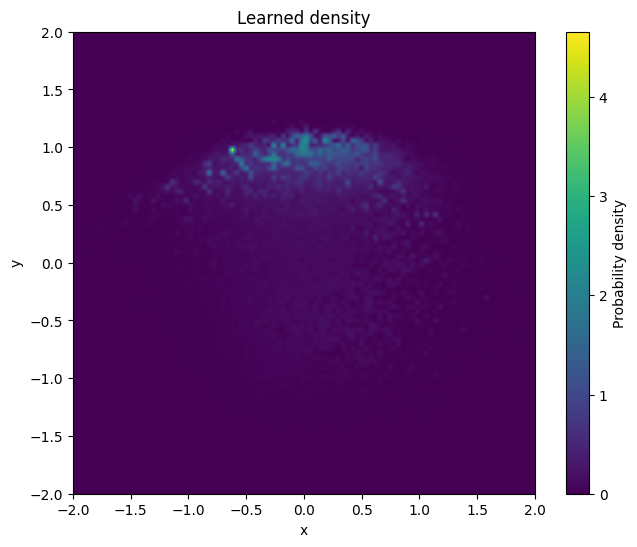

In [17]:
# Density of the ANODE
rng_key, plotting_key_ANODE = jax.random.split(rng_key)
_, log_densities_ANODE = model_ANODE.get_logp(state_ANODE.params, plotting_points, plotting_key_ANODE)
densities_ANODE = jnp.exp(log_densities_ANODE).reshape(X.shape)

plt.figure(figsize=(8, 6))
plt.imshow(densities_ANODE, extent=(-2, 2, -2, 2), origin='lower', cmap='viridis', interpolation='bilinear')
plt.colorbar(label='Probability density')
plt.title('Learned density')
plt.xlabel('x')
plt.ylabel('y')
plt.show()